In [ ]:
#auto-complete
%config Completer.use_jedi = False

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks
!ls

/content/drive/My Drive/Colab Notebooks
baseline_trained		 baseline_trained_sobel  cs4243NEWdata
baseline_trained_dropout	 better_trained		 cs4243_smallest
baseline_trained_regularization  ComputerVision4243	 cs4243_smallest_a
baseline_trained_shuffle	 CS4234.gdoc		 model.png


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

img_height = 256
img_width = 256
image_size = (img_height, img_width)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/",
    labels='inferred',
    validation_split=0.2,
    subset="training",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/",
    labels='inferred',
    validation_split=0.2,
    subset="validation",
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)

whole_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/cs4243NEWdata/",
    labels='inferred',
    seed=110,
    image_size=image_size,
    batch_size=batch_size,
)
print(type(val_ds))
class_names = train_ds.class_names
print(class_names)

Found 1516 files belonging to 3 classes.
Using 1213 files for training.
Found 1516 files belonging to 3 classes.
Using 303 files for validation.
Found 1516 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
['carrying', 'normal', 'threat']


(16, 256, 256, 3)
(16,)


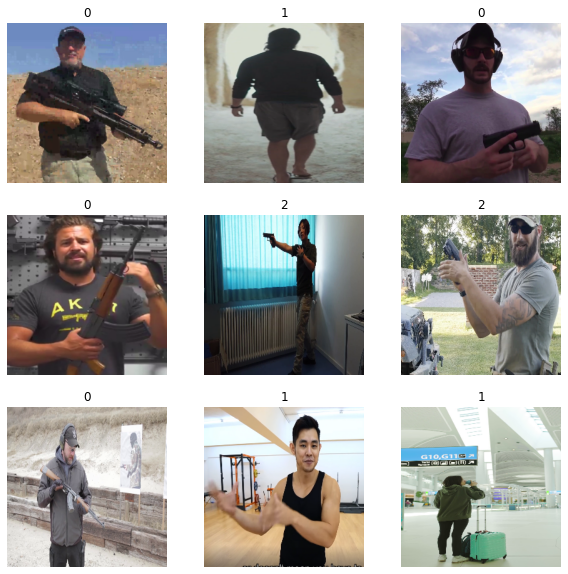

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
import numpy as np
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[np.square(0.299), 
                                np.square(0.224), 
                                np.square(0.225)])
  ]
)

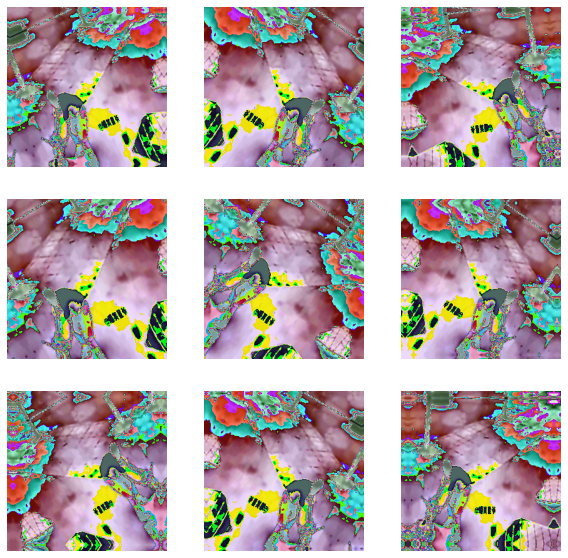

In [ ]:
# showing the rotated and flipped images that were added to the 
# original dataset
#
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [ ]:

#Configure the dataset for performance
augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y))
#augmented_val_ds = val_ds.map( lambda x, y: (data_augmentation(x, training=True), y))

augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
#augmented_val_ds = augmented_val_ds.prefetch(buffer_size=32)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
#standardization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

model = Sequential([
    # layer 0
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # layer 1
    layers.Conv2D(16, (3,3), padding='same', activation='relu', use_bias=True),
    layers.MaxPooling2D(2,2),
    # layer 2
    layers.Conv2D(32, (3,3), padding='same', activation = 'relu', use_bias=True),
    layers.MaxPooling2D(2,2),
    # layer 3
    layers.Conv2D(64, (3,3), padding='same', activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D(2,2),
    # layer 4
    layers.Conv2D(128, (3,3), padding='same', activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D(2,2),
    # layer 5
    layers.Conv2D(256, (3,3), padding='same', activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    # layer 6
    layers.Dense(512, activation = 'relu', use_bias=True, kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    layers.Dropout( 0.2),
    # layer 7
    layers.Dense(num_classes, activation='softmax', use_bias=True)
    
])

In [ ]:
#opimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)       

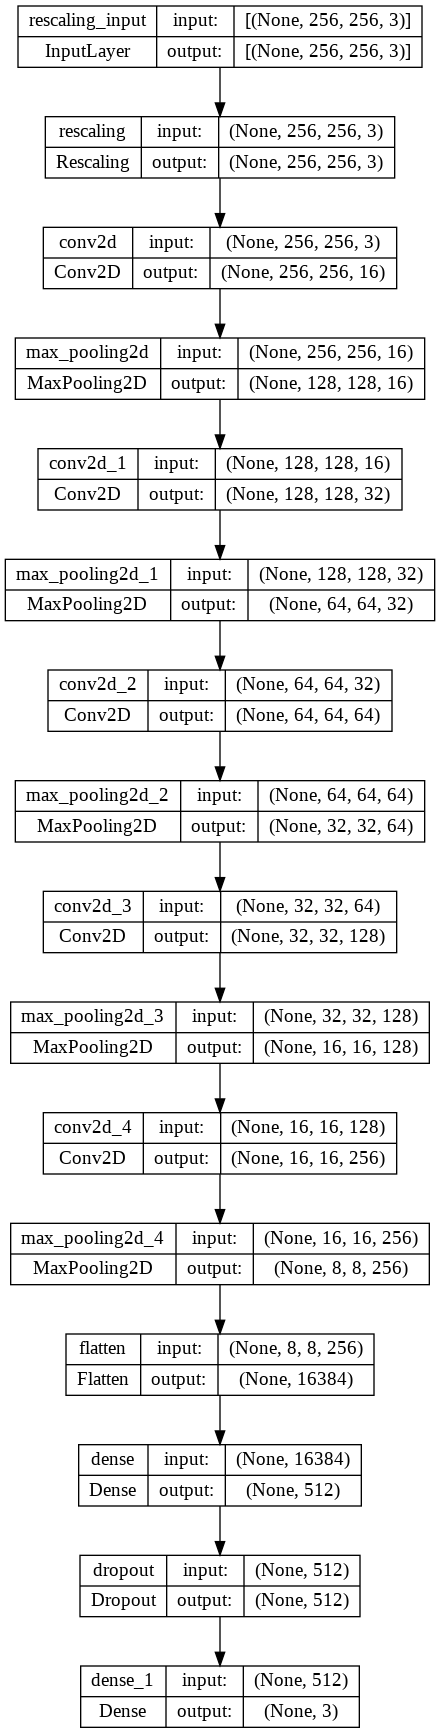

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs=100
history = model.fit(
  augmented_train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


76/76 [==============================] - 331s 4s/step - loss: 4.5812 - accuracy: 0.3355 - val_loss: 2.1348 - val_accuracy: 0.3432
Epoch 2/100
76/76 [==============================] - 57s 696ms/step - loss: 1.7730 - accuracy: 0.3471 - val_loss: 1.5400 - val_accuracy: 0.3432
Epoch 3/100
76/76 [==============================] - 58s 714ms/step - loss: 1.4328 - accuracy: 0.3471 - val_loss: 1.3494 - val_accuracy: 0.3432
Epoch 4/100
76/76 [==============================] - 56s 691ms/step - loss: 1.3000 - accuracy: 0.3471 - val_loss: 1.2585 - val_accuracy: 0.3432
Epoch 5/100
76/76 [==============================] - 56s 692ms/step - loss: 1.2311 - accuracy: 0.3471 - val_loss: 1.2072 - val_accuracy: 0.3432
Epoch 6/100
76/76 [==============================] - 56s 692ms/step - loss: 1.1903 - accuracy: 0.3471 - val_loss: 1.1755 - val_accuracy: 0.3432
Epoch 7/100
76/76 [==============================] - 57s 695ms/step - loss: 1.1647 - accuracy: 0.3471 - val_loss: 1.1548 - val_accuracy: 0.3432
Epoch 

In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()
show_final_history(history)#

In [ ]:
model.save('baseline_trained_regularization_100')

In [ ]:
print(model)

In [ ]:
import os
import numpy as np
from os import listdir
# make confution matrix
confution_matrix = np.zeros((3,3), dtype=int)


# get the path/directory
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/baseline_trained_regularization_100')
predictions = model.predict(whole_ds)

In [ ]:
predictions.shape

In [ ]:
# if already 0-2, then this part no need
predicted_class = np.argmax(predictions, axis=1)
print(predicted_class)
print(np.min(predicted_class))
print(np.max(predicted_class))

In [ ]:
labeled_class = np.concatenate([label for img, label in whole_ds], axis = 0)#bacause labels form dataset are 1-3 so need to -1

In [ ]:
print(np.min(labeled_class))
print(np.max(labeled_class))

In [ ]:
print(labeled_class)

In [ ]:
# confusion matrix
# https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
# confusion_matrix(labels, predictions)
# The rows of the matrix represent the labels
# tf.math.confusion_matrix(labeled_class, predicted_class)

confusion_matrix = tf.math.confusion_matrix(
    labeled_class,
    predicted_class,
    num_classes=3,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
print(confusion_matrix)

In [ ]:
print("correct 0 percentage is:", 100* confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[0][2]))
print("correct 1 percentage is:", 100* confusion_matrix[1][1]/(confusion_matrix[1][0]+confusion_matrix[1][1]+confusion_matrix[1][2]))
print("correct 2 percentage is:", 100* confusion_matrix[2][2]/(confusion_matrix[2][0]+confusion_matrix[2][1]+confusion_matrix[2][2]))

In [ ]:
# print("correct 0 percentage is:", 100* confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]+confusion_matrix[2][0]))
# print("correct 1 percentage is:", 100* confusion_matrix[1][1]/(confusion_matrix[0][1]+confusion_matrix[1][1]+confusion_matrix[2][1]))
# print("correct 2 percentage is:", 100* confusion_matrix[2][2]/(confusion_matrix[0][2]+confusion_matrix[1][2]+confusion_matrix[2][2]))